In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive


In [ ]:
import os
import shutil
import cv2
import pandas as pd
import numpy as np
# Import the deep learning libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,random_split
from torchvision import models, transforms
from skimage.exposure import match_histograms
import random
from skimage.io import imread
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm


In [ ]:
class IsCarRealModel(nn.Module):
    def __init__(self, pretrained=True):
        super(IsCarRealModel, self).__init__()
        self.resnet = models.resnet152(pretrained=pretrained)

        # Replace avgpool for flexibility
        self.resnet.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Custom FC head
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_ftrs, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.resnet(x)

In [ ]:
# Load best model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = IsCarRealModel(pretrained=True)
model = model.to(device)
model.load_state_dict(torch.load('best_car_real_model_resnet152.pth'))
model.to(device)

Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


IsCarRealModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
    

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image

def predict_image(image_path, model, device):
    if not os.path.exists(image_path):
        print(f"File not found: {image_path}")
        return None, None

    # Ensure model is in evaluation mode
    model.eval()

    # Must match input size expected by the model
    # Image preprocessing
    transform = transforms.Compose([
        transforms.Resize((480, 640)),
        transforms.ToTensor(),
    ])

    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    image = image.unsqueeze(0)
    image = image.to(device)

    # Make prediction
    with torch.no_grad():
        output = model(image)
        prob = torch.sigmoid(output).item()
        prediction = 1 if prob >= 0.5 else 0

    # Output label_map = {'not': 0, 'real': 1}
    print(f"Prediction: {'Real (1)' if prediction == 1 else 'Not Real (0)'} | Probability: {prob:.4f}")
    return prediction, prob

In [ ]:
!pip install grad-cam

In [ ]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50
from cv2 import resize, INTER_LINEAR
import matplotlib.pyplot as plt



In [ ]:
def get_canny_edge(img, threshold1=30, threshold2=80):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = gray * 255
    gray = gray.astype(np.uint8)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    edge = 255 - cv2.Canny(gray, threshold1, threshold2)
    edge = np.stack([edge] * 3, axis=-1) / 255
    return edge

class WrappedBinaryModel(torch.nn.Module):

    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model

    def forward(self, x):
        logit = self.base_model(x)
        logit = logit.view(-1, 1)
        two_logits = torch.cat([-logit, logit], dim=1)
        return two_logits


def visualize_grad_cam(image_path, gt_class, model, target_layer, device):
    transform = transforms.Compose([
        transforms.Resize((480, 640)),
        transforms.ToTensor()
    ])

    image_pil = Image.open(image_path).convert('RGB')
    image_tensor = transform(image_pil).unsqueeze(0).to(device)
    rgb_image = np.array(image_pil.resize((224, 224))) / 255.0

    edge_map = get_canny_edge((rgb_image * 255).astype(np.uint8))

    # Wrap the model for Grad-CAM compatibility
    wrapped_model = WrappedBinaryModel(model)
    cam = GradCAM(model=wrapped_model, target_layers=[target_layer])

    heatmaps = {}
    for class_id in [0, 1]:
        targets = [ClassifierOutputTarget(class_id)]
        grayscale_cam = cam(input_tensor=image_tensor, targets=targets)[0]
        grayscale_cam_resized = cv2.resize(grayscale_cam, (edge_map.shape[1], edge_map.shape[0]), interpolation=cv2.INTER_LINEAR)
        heatmap = show_cam_on_image(edge_map, grayscale_cam_resized, use_rgb=True)
        heatmaps[f"class_{class_id}"] = heatmap

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(rgb_image)
    ax[0].set_title("Original Image")
    ax[1].imshow(heatmaps["class_0"])
    ax[1].set_title("Grad-CAM: Class 'Spoof'")
    ax[2].imshow(heatmaps["class_1"])
    ax[2].set_title("Grad-CAM: Class 'Real'")

    for a in ax:
        a.axis('off')
    plt.tight_layout()
    plt.show()


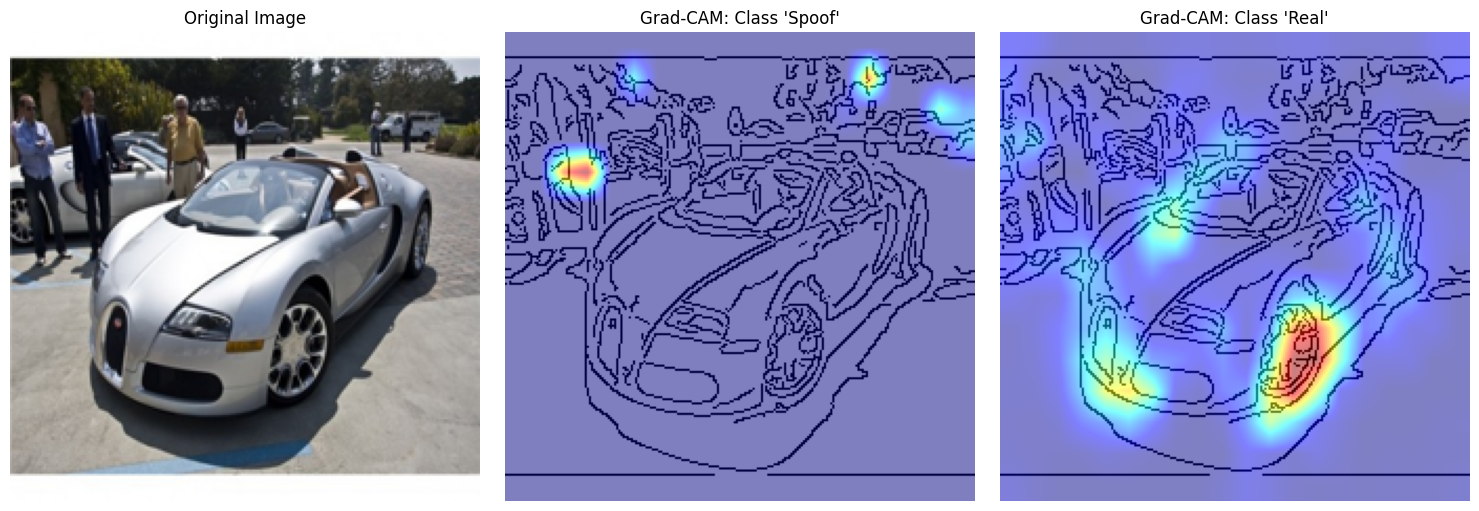

Prediction: Real (1) | Probability: 1.0000


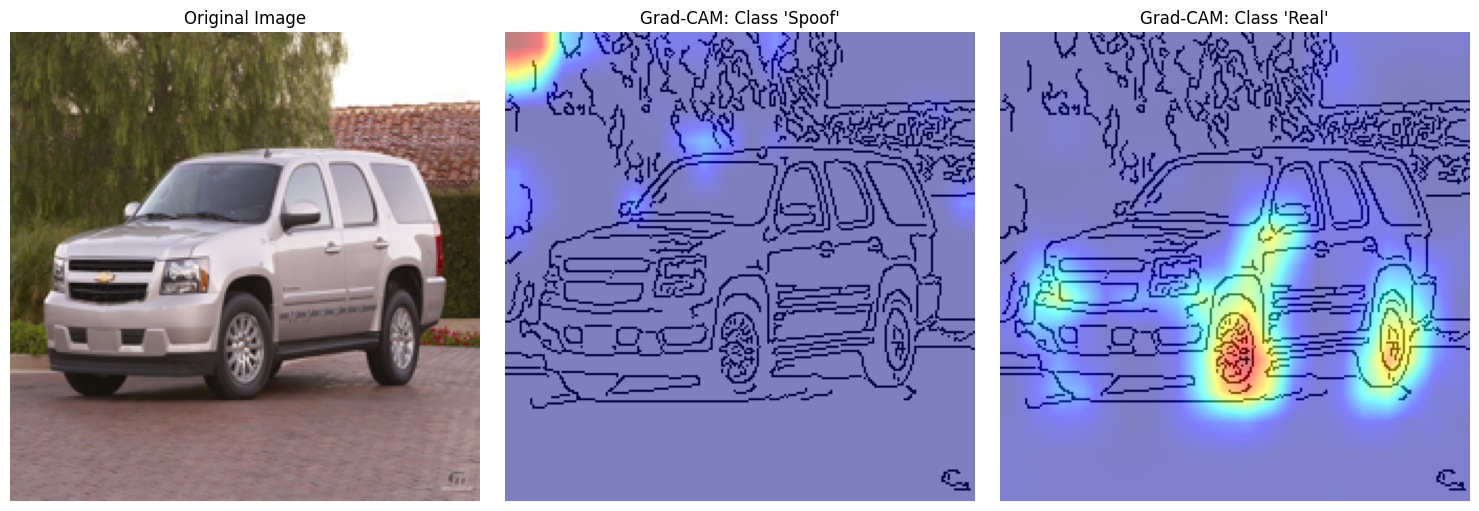

Prediction: Real (1) | Probability: 1.0000


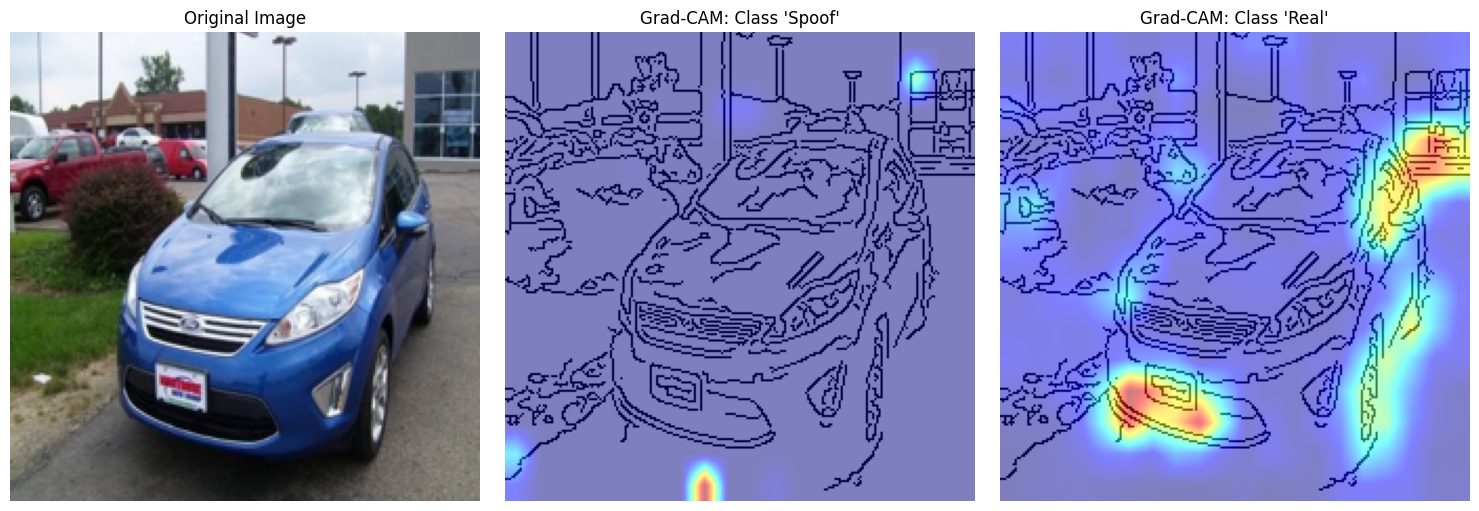

Prediction: Real (1) | Probability: 1.0000


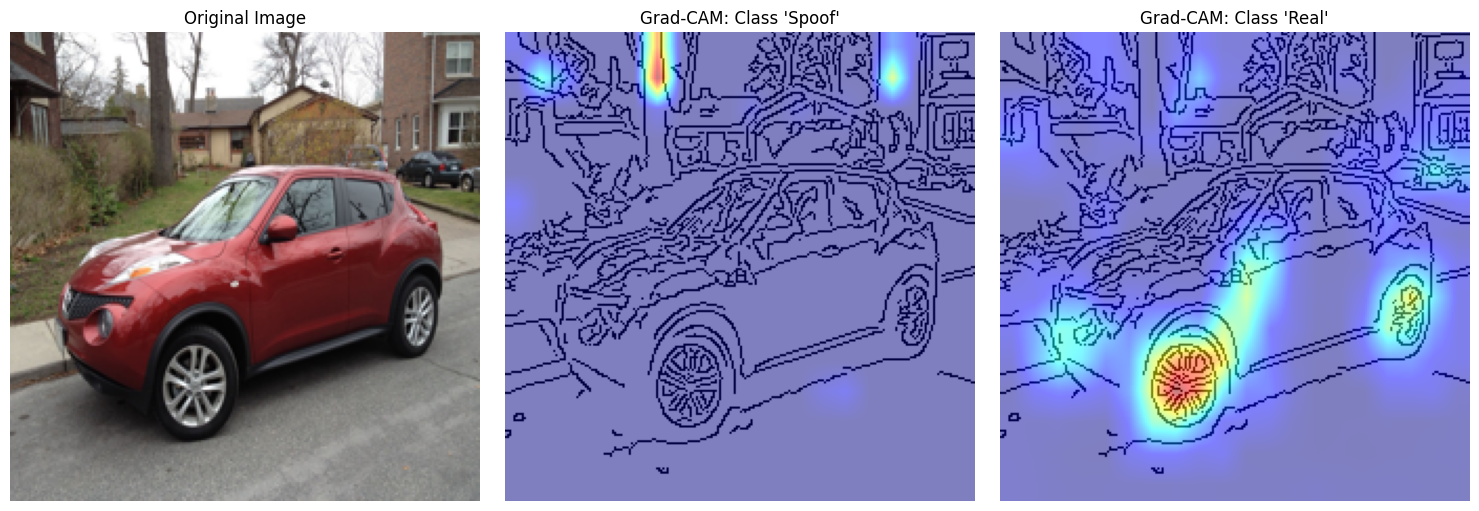

Prediction: Real (1) | Probability: 1.0000


(1, 1.0)

In [ ]:
# Image and Grad-CAM
img_path = './grad_cam/grad_cam_test_images/0161.jpg'
gt_class = 1  # Output label_map = {'not': 0, 'real': 1}

# Final conv layer
target_layer = model.resnet.layer4[-1]
visualize_grad_cam(img_path, gt_class, model, target_layer, device)
predict_image(img_path, model, device)

img_path = './grad_cam/grad_cam_test_images/0229.jpg'
gt_class = 1  # Output label_map = {'not': 0, 'real': 1}

target_layer = model.resnet.layer4[-1]
visualize_grad_cam(img_path, gt_class, model, target_layer, device)
predict_image(img_path, model, device)

img_path = './grad_cam/grad_cam_test_images/0459.jpg'
gt_class = 1  # Output label_map = {'not': 0, 'real': 1}

target_layer = model.resnet.layer4[-1]
visualize_grad_cam(img_path, gt_class, model, target_layer, device)
predict_image(img_path, model, device)

img_path = './grad_cam/grad_cam_test_images/0674.jpg'
gt_class = 1  # Output label_map = {'not': 0, 'real': 1}

target_layer = model.resnet.layer4[-1]
visualize_grad_cam(img_path, gt_class, model, target_layer, device)
predict_image(img_path, model, device)

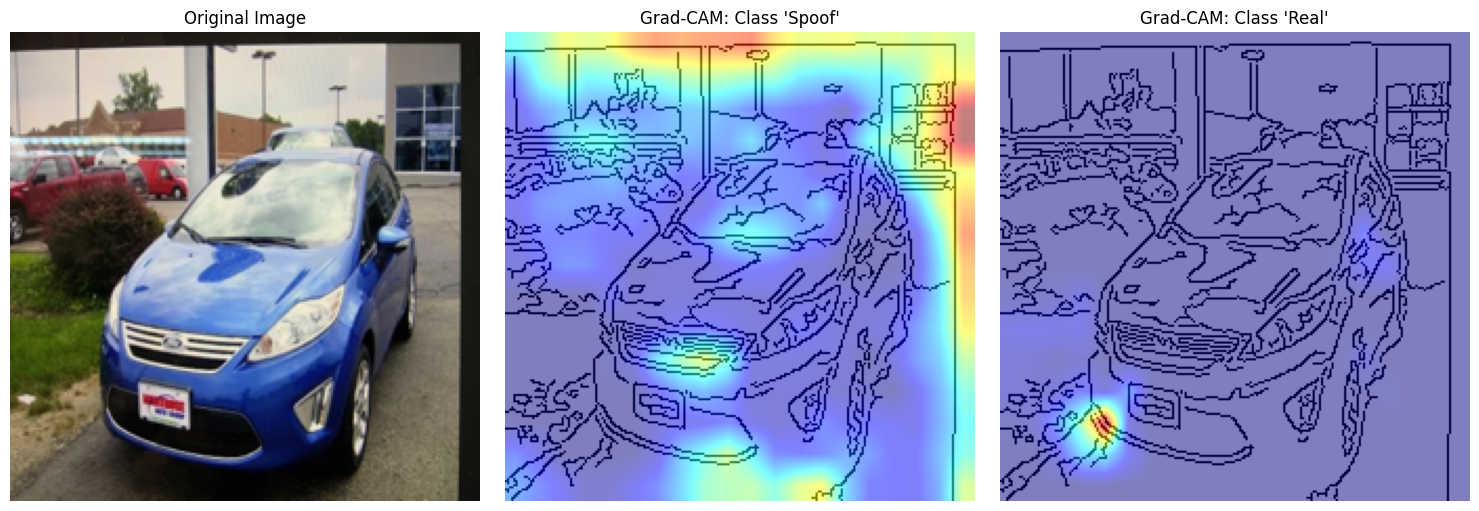

Prediction: Not Real (0) | Probability: 0.0000


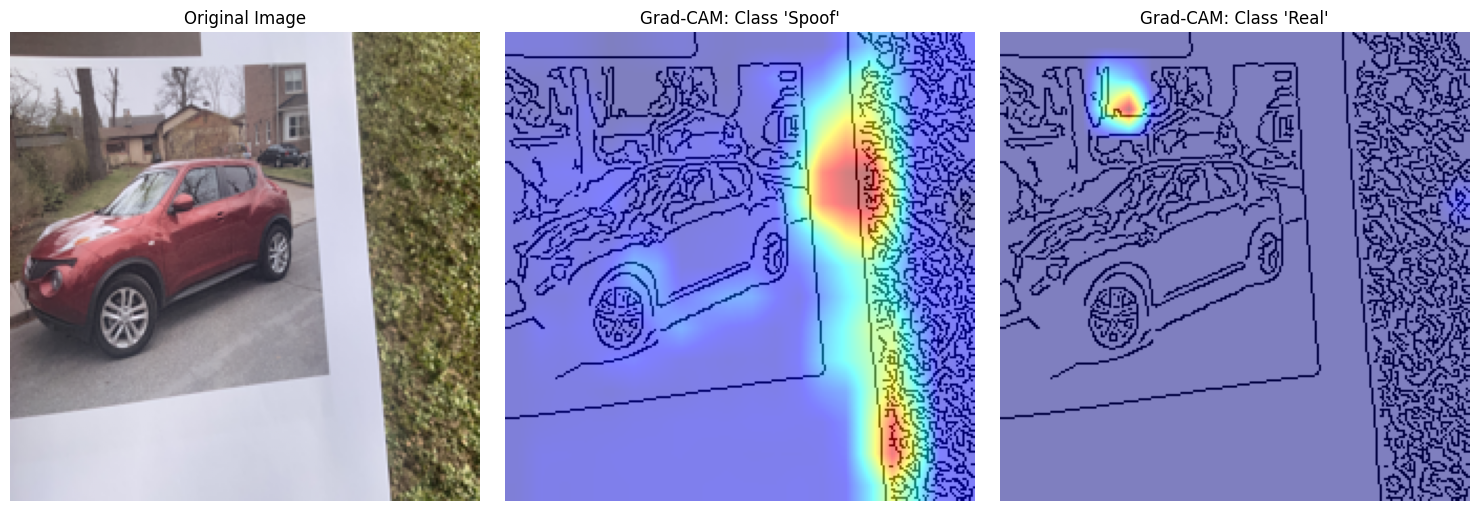

Prediction: Not Real (0) | Probability: 0.0000


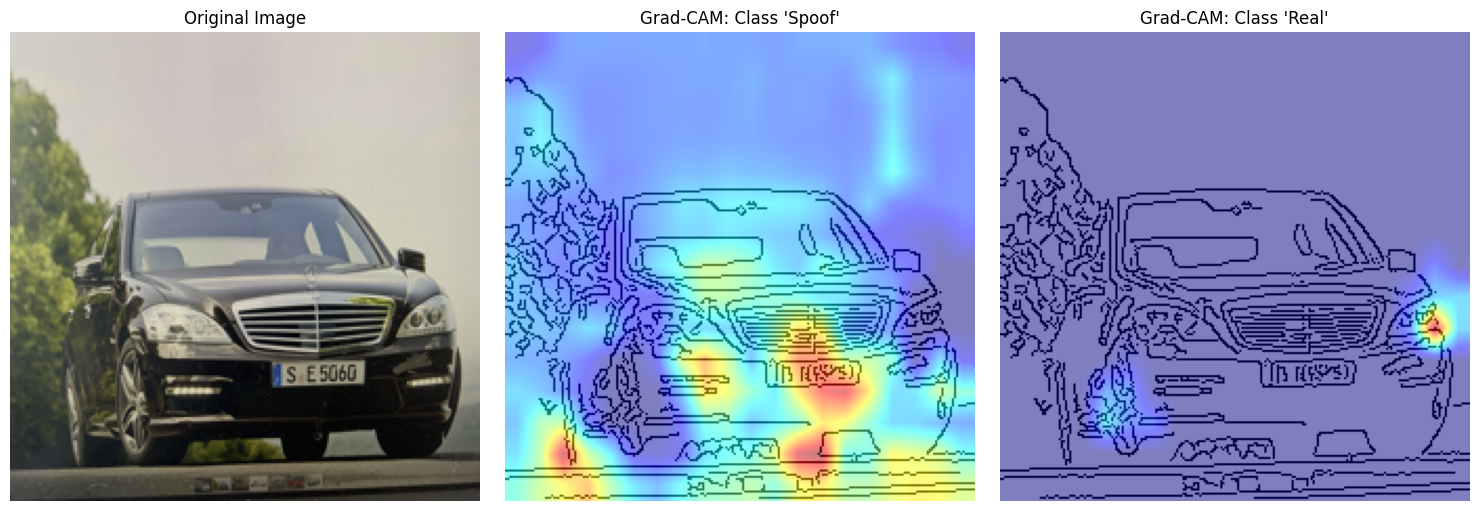

Prediction: Not Real (0) | Probability: 0.0000


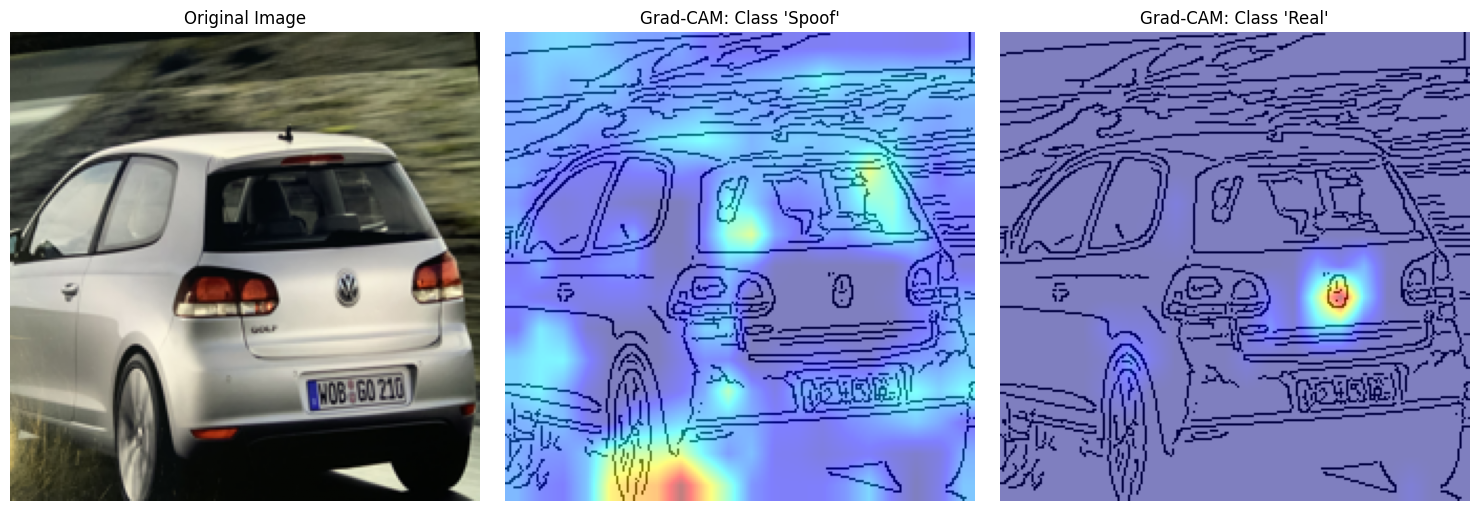

Prediction: Not Real (0) | Probability: 0.0000


(0, 1.0765630609199661e-09)

In [ ]:
# Image and Grad-CAM
img_path = './grad_cam/grad_cam_test_images/IMG_0022.jpeg'
gt_class = 0  # Output label_map = {'not': 0, 'real': 1}

# Final conv layer
target_layer = model.resnet.layer4[-1]
visualize_grad_cam(img_path, gt_class, model, target_layer, device)
predict_image(img_path, model, device)

img_path = './grad_cam/grad_cam_test_images/IMG_0100.jpeg'
gt_class = 0  # Output label_map = {'not': 0, 'real': 1}

target_layer = model.resnet.layer4[-1]
visualize_grad_cam(img_path, gt_class, model, target_layer, device)
predict_image(img_path, model, device)

img_path = './grad_cam/grad_cam_test_images/IMG_0122.jpeg'
gt_class = 0  # Output label_map = {'not': 0, 'real': 1}

target_layer = model.resnet.layer4[-1]
visualize_grad_cam(img_path, gt_class, model, target_layer, device)
predict_image(img_path, model, device)

img_path = './grad_cam/grad_cam_test_images/IMG_0158.jpeg'
gt_class = 0  # Output label_map = {'not': 0, 'real': 1}

target_layer = model.resnet.layer4[-1]
visualize_grad_cam(img_path, gt_class, model, target_layer, device)
predict_image(img_path, model, device)

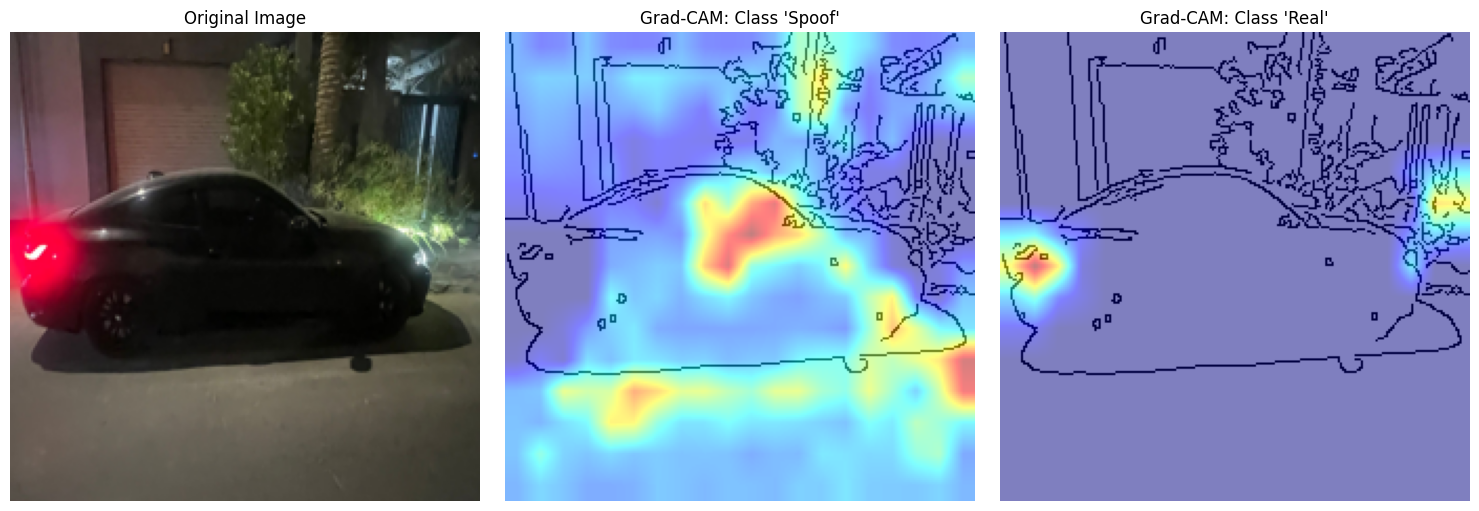

Prediction: Not Real (0) | Probability: 0.0000


(0, 8.368240544953665e-10)

In [ ]:
img_path = './grad_cam/grad_cam_test_images/image 1.JPG'
gt_class = 1  # Output label_map = {'not': 0, 'real': 1}

target_layer = model.resnet.layer4[-1]
visualize_grad_cam(img_path, gt_class, model, target_layer, device)
predict_image(img_path, model, device)